In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import imageio
from pathlib import Path
from typing import Tuple, Callable, Optional, List
import imageio


from flygym.arena.mujoco_arena import (
    FlatTerrain,
    GappedTerrain,
    BlocksTerrain,
    MixedTerrain,
)
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs
import flygym.util.vision as vision
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain
from flygym.util.data import color_cycle_rgb


Load kinematic replay data

In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [4]:
class ObstacleOdorArena(BaseArena):

    num_sensors = 4
    
    def __init__(
        self,
        terrain: BaseArena,
        odor_source: np.ndarray = np.array([[35, 10, 1]]),
        peak_intensity: np.ndarray = np.array([[1]]),
        diffuse_func: Callable = lambda x: x**-2,
        marker_colors: Optional[List[Tuple[float, float, float, float]]] = None,
        marker_size: float = 0.1,
        walls_dist: Tuple[float, float] = (12, 5),
        walls_dims: Tuple[float, float, float] = (0.5, 6, 2),
        cam_pos: Tuple[float, float, float] = (-5, -5, 7),
        cam_angle: Tuple[float, float, float] = (0, -1.2, -np.pi / 2),
        wall_colors = [(0,0,0,1), (0,0,0,1)]
    ):
        self.terrain_arena = terrain
        self.root_element = terrain.root_element
        self.friction = terrain.friction
        z_offset = terrain.get_spawn_position(np.zeros(3), np.zeros(3))[0][2]

        self.odor_source = np.array(odor_source)
        self.peak_odor_intensity = np.array(peak_intensity)
        self.num_odor_sources = self.odor_source.shape[0]
        if self.odor_source.shape[0] != self.peak_odor_intensity.shape[0]:
            raise ValueError(
                "Number of odor source locations and peak intensities must match."
            )
        self.odor_dim = self.peak_odor_intensity.shape[1]
        self.diffuse_func = diffuse_func

        # Add markers at the odor sources
        if marker_colors is None:
            marker_colors = []
            num_odor_sources = self.odor_source.shape[0]
            for i in range(num_odor_sources):
                rgb = np.array(color_cycle_rgb[i % num_odor_sources]) / 255
                rgba = (*rgb, 1)
                marker_colors.append(rgba)
        for i, (pos, rgba) in enumerate(zip(self.odor_source, marker_colors)):
            pos = list(pos)
            pos[2] += z_offset
            marker_body = self.root_element.worldbody.add(
                "body", name=f"odor_source_marker_{i}", pos=pos, mocap=True
            )
            marker_body.add(
                "geom", type="capsule", size=(marker_size, marker_size), rgba=rgba
            )

        # Reshape odor source and peak intensity arrays to simplify future claculations
        _odor_source_repeated = self.odor_source[:, np.newaxis, np.newaxis, :]
        _odor_source_repeated = np.repeat(_odor_source_repeated, self.odor_dim, axis=1)
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.num_sensors, axis=2
        )
        self._odor_source_repeated = _odor_source_repeated
        _peak_intensity_repeated = self.peak_odor_intensity[:, :, np.newaxis]
        _peak_intensity_repeated = np.repeat(
            _peak_intensity_repeated, self.num_sensors, axis=2
        )
        self._peak_intensity_repeated = _peak_intensity_repeated

        # Add monitor camera
        cam_pose = list(cam_pos)
        cam_pose[2] += z_offset
        self.root_element.worldbody.add(
            "camera",
            name="arena_camera_1",
            mode="fixed",
            pos=cam_pos,
            euler=cam_angle,
            fovy=50,
        )

        # Add obstacles
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )

        self.walls_positions = [
            np.array([walls_dist[0], walls_dist[1], walls_dims[2]/2 + z_offset]), 
            np.array([2*walls_dist[0], -walls_dist[1], walls_dims[2]/2 + z_offset])
        ]

        for wall_pos, wall_color in zip(self.walls_positions, wall_colors):
            self.root_element.worldbody.add(
                "geom",
                type="box",
                size=walls_dims,
                pos=wall_pos,
                rgba=wall_color,
                material=obstacle,
                friction=self.friction,
            )
    
    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return self.terrain_arena.get_spawn_position(rel_pos, rel_angle)
    
    def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        antennae_pos_repeated = antennae_pos[np.newaxis, np.newaxis, :, :]
        dist_3d = antennae_pos_repeated - self._odor_source_repeated  # (n, k, w, 3)
        dist_euc = np.linalg.norm(dist_3d, axis=3)  # (n, k, w)
        scaling = self.diffuse_func(dist_euc)  # (n, k, w)
        intensity = self._peak_intensity_repeated * scaling  # (n, k, w)
        return intensity.sum(axis=0)  # (k, w)

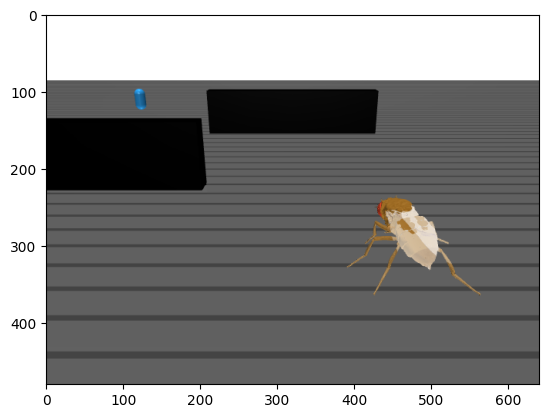

In [5]:
terrain_arena = GappedTerrain(x_range=(-20, 70), y_range=(-50, 50))
arena = ObstacleOdorArena(terrain=terrain_arena, marker_size=0.5)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="arena_camera_1", enable_vision=True, render_raw_vision=True, enable_olfaction=True)
# sim_params = MuJoCoParameters(render_playspeed=0.2, render_raw_vision=True)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(5, -8, 0.5),
    spawn_orient=(0, 0, 1, 0.2)
)
for i in range(100):
    joint_pos = data_block[:, 0]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

plt.imshow(nmf._frames[-1])
imageio.imwrite('outputs/arena_overview.png', nmf._frames[-1])

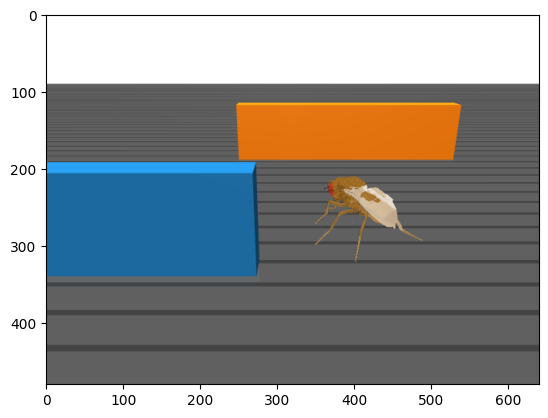

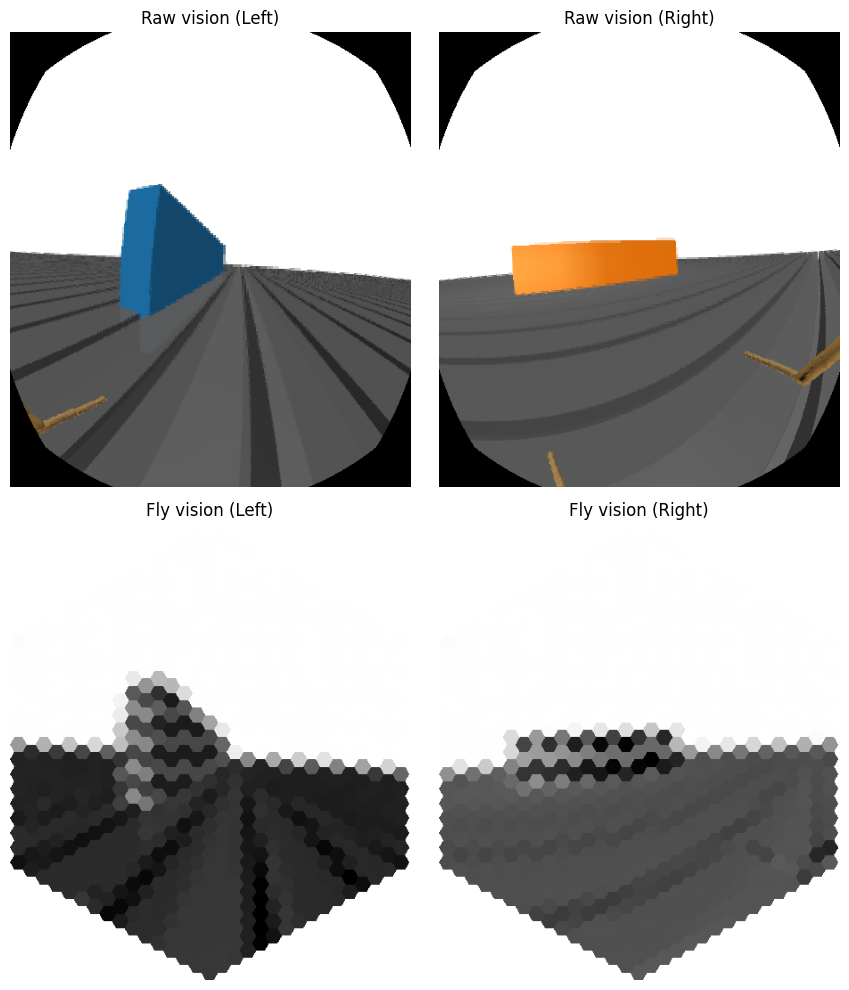

In [6]:
terrain_arena = GappedTerrain(x_range=(-20, 70), y_range=(-50, 50))
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    marker_size=0.5,
    marker_colors=[(0.5, 0.5, 0.5, 0)],
    cam_pos=(2, -2, 7),
    cam_angle=(0, -1.2, -np.pi / 2),
    wall_colors=[[0.12, 0.47, 0.71, 1], [1.00, 0.50, 0.05, 1]]
)
sim_params = MuJoCoParameters(
    render_playspeed=0.2,
    render_camera="arena_camera_1",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
# sim_params = MuJoCoParameters(render_playspeed=0.2, render_raw_vision=True)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(14, -4, 0.5),
    spawn_orient=(0, 0, 1, 0.7),
)
for i in range(100):
    joint_pos = data_block[:, 0]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

plt.imshow(nmf._frames[-1])
plt.show()
imageio.imwrite("outputs/vision_sim_env.png", nmf._frames[-1])

vision_raw = obs["raw_vision"]
vision_human_readable = [
    vision.hex_pxls_to_human_readable(obs["vision"][i], vision.ommatidia_id_map)
    for i in range(2)
]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)
for i, side in enumerate(["Left", "Right"]):
    axs[0, i].imshow(vision_raw[i])
    axs[0, i].set_title(f"Raw vision ({side})")
    axs[0, i].axis("off")
    axs[1, i].imshow(vision_human_readable[i], cmap="gray")
    axs[1, i].set_title(f"Fly vision ({side})")
    axs[1, i].axis("off")
plt.savefig("outputs/vision_sim.pdf")